#Run Simulation

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import matplotlib
import pickle

confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
path_to_save = '../../figures/'
path_data = '../../data/'

In [44]:
def delay_cases(new_I_t, len_new_I_t, len_new_cases_obs , delay, delay_arr):
    """
    Delays the input new_I_t by delay and return and array with length len_new_cases_obs
    The initial delay of the output is set by delay_arr. 
    
    Take care that delay is smaller or equal than delay_arr, otherwise zeros are 
    returned, which could potentially lead to errors

    Also assure that len_new_I_t is larger then len(new_cases_obs)-delay, otherwise it 
    means that the simulated data is not long enough to be fitted to the data.
    """
    delay_mat = make_delay_matrix(n_rows=len_new_I_t, 
                                  n_columns=len_new_cases_obs, initial_delay=delay_arr)
    inferred_cases = interpolate(new_I_t, delay, delay_mat)
    return inferred_cases 

def make_delay_matrix(n_rows, n_columns, initial_delay=0):
    """
    Has in each entry the delay between the input with size n_rows and the output
    with size n_columns
    """
    size = max(n_rows, n_columns)
    mat = np.zeros((size, size))
    for i in range(size):
        diagonal = np.ones(size-i)*(initial_delay + i)
        mat += np.diag(diagonal, i)
    for i in range(1, size):
        diagonal = np.ones(size-i)*(initial_delay - i)
        mat += np.diag(diagonal, -i)
    return mat[:n_rows, :n_columns]

def interpolate(array, delay, delay_matrix):
    interp_matrix = tt.maximum(1-tt.abs_(delay_matrix - delay), 0)
    interpolation = tt.dot(array,interp_matrix)
    return interpolation


In [45]:
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time

date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,3,15)
num_days_to_predict = 28


diff_data_sim = 16 # should be significantly larger than the expected delay, in 
                   # order to always fit the same number of data points.
date_begin_sim = date_data_begin - datetime.timedelta(days = diff_data_sim)
format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
#cases_obs = np.concatenate([np.nan*np.ones(diff_data_sim), cases_obs])
print('Cases yesterday ({}): {} and '
      'day before yesterday: {}'.format(date_data_end.isoformat(), *cases_obs[:-3:-1]))
num_days = (date_data_end - date_begin_sim).days
date_today = date_data_end + datetime.timedelta(days=1)
# ------------------------------------------------------------------------------ #
# model setup and training
# ------------------------------------------------------------------------------ #
np.random.seed(0)

def SIR_model(λ, μ, S_begin, I_begin, N):
    new_I_0 = tt.zeros_like(I_begin)
    def next_day(λ, S_t, I_t, _):
        new_I_t = λ/N*I_t*S_t
        S_t = S_t - new_I_t
        I_t = I_t + new_I_t - μ * I_t
        return S_t, I_t, new_I_t
    outputs , _  = theano.scan(fn=next_day, sequences=[λ], 
                               outputs_info=[S_begin, I_begin, new_I_0])
    S_all, I_all, new_I_all = outputs
    return S_all, I_all, new_I_all

with pm.Model() as model:
    # true cases at begin of loaded data but we do not know the real number
    I_begin = pm.HalfCauchy('I_begin', beta=100)

    # fraction of people that are newly infected each day
    λ = pm.Lognormal("λ", mu=np.log(0.4), sigma=0.5)

    # fraction of people that recover each day, recovery rate mu
    μ = pm.Lognormal('μ', mu=np.log(1/8), sigma=0.2)

    # delay in days between contracting the disease and being recorded
    delay = pm.Lognormal("delay", mu=np.log(8), sigma=0.2)

    # prior of the error of observed cases
    σ_obs = pm.HalfCauchy("σ_obs", beta=10)

    N_germany = 83e6

    # -------------------------------------------------------------------------- #
    # training the model with loaded data
    # -------------------------------------------------------------------------- #

    S_begin = N_germany - I_begin
    S_past, I_past, new_I_past = SIR_model(λ=λ * tt.ones(num_days-1), μ=μ, 
                                               S_begin=S_begin, I_begin=I_begin,
                                               N=N_germany)
    new_cases_obs = np.diff(cases_obs)
    new_cases_inferred = delay_cases(new_I_past, len_new_I_t=num_days - 1, 
                                     len_new_cases_obs=len(new_cases_obs), 
                                     delay=delay, delay_arr=diff_data_sim)

    # Approximates Poisson
    # calculate the likelihood of the model:
    # observed cases are distributed following studentT around the model
    pm.StudentT(
        "obs",
        nu=4,
        mu=new_cases_inferred,
        sigma=(new_cases_inferred)**0.5 * σ_obs,
        observed=new_cases_obs)  
    
    S_past = pm.Deterministic('S_past', S_past)
    I_past = pm.Deterministic('I_past', I_past)
    new_I_past = pm.Deterministic('new_I_past', new_I_past)
    new_cases_past = pm.Deterministic('new_cases_past', new_cases_inferred)
    
    # -------------------------------------------------------------------------- #
    # prediction, start with no changes in policy
    # -------------------------------------------------------------------------- #

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_no_change = SIR_model(λ=λ*tt.ones(num_days_to_predict), μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, N=N_germany)
    S_no_change, I_no_change, new_I_no_change = forecast_no_change

    #saves the variables for later retrieval
    pm.Deterministic('S_no_change', S_no_change)
    pm.Deterministic('I_no_change', I_no_change)
    pm.Deterministic('new_I_no_change', new_I_no_change)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_no_change]), 
                                     len_new_I_t=diff_data_sim + num_days_to_predict, 
                                     len_new_cases_obs=num_days_to_predict, 
                                     delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_no_change', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # social distancing, m reduced by about 50 percent
    # -------------------------------------------------------------------------- #
    #For all following predictions:
    length_transient = 7  # days


    # λ is decreased by 50%
    reduc_factor_mild = 0.5
    days_offset = 0  # start the decrease in spreading rate after this

    time_arr = np.arange(num_days_to_predict)

    # change in m along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_soc_dist= λ * (1 - λ_correction * reduc_factor_mild) 

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_soc_dist = SIR_model(λ=λ_t_soc_dist, μ=μ, 
                        S_begin=S_begin, I_begin=I_begin, 
                        N=N_germany)
    S_soc_dist, I_soc_dist, new_I_soc_dist = forecast_soc_dist
    pm.Deterministic('S_soc_dist', S_soc_dist)
    pm.Deterministic('I_soc_dist', I_soc_dist)
    pm.Deterministic('new_I_soc_dist', new_I_soc_dist)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_soc_dist]), 
                                    len_new_I_t=diff_data_sim + num_days_to_predict, 
                                    len_new_cases_obs=num_days_to_predict, 
                                    delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_soc_dist', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 0  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_isol', S_isol)
    pm.Deterministic('I_isol', I_isol)  
    pm.Deterministic('new_I_isol', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # isolation 5 days later, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol_later= λ * (1 - λ_correction * reduc_factor_strong) 

    S_begin = S_past[-1]
    I_S_beginbegin = I_past[-1]
    forecast_isol_later = SIR_model(λ=λ_t_isol_later, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_isol_later, I_isol_later, new_I_isol_later = forecast_isol_later

    pm.Deterministic('S_isol_later', S_isol_later)
    pm.Deterministic('I_isol_later', I_isol_later)  
    pm.Deterministic('new_I_isol_later', new_I_isol_later)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol_later]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_isol_later', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # isolation 5 days earlier, almost no new infections besides baseline after transient phase
    # -------------------------------------------------------------------------- #

    length_transient = 7

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -5  # start the decrease in spreading rate after this

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset, num_days_to_predict)

    # change in λ along time

    λ_t_earlier  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset]
    I_begin = I_past[-1 + days_offset]
    forecast_earlier = SIR_model(λ=λ_t_earlier, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_earlier, I_earlier, new_I_earlier = forecast_earlier

    pm.Deterministic('S_earlier', S_earlier)
    pm.Deterministic('I_earlier', I_earlier)  
    pm.Deterministic('new_I_earlier', new_I_earlier)
    pm.Deterministic('λ_t_earlier', λ_t_earlier)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset], new_I_earlier]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    
    pm.Deterministic('new_cases_earlier', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # long transient scenario
    # -------------------------------------------------------------------------- #

    length_transient = 14

    # λ is decreased by 90%
    reduc_factor = 0.9
    days_offset = -3.5  # start the decrease in spreading rate after this
    days_offset_sim = -4

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(days_offset_sim, num_days_to_predict)

    # change in λ along time

    λ_t_long_trans  = tt.clip((time_arr-days_offset) / length_transient, 0, 1)*\
                      (λ*(1-reduc_factor) - λ) + λ


    S_begin = S_past[-1 + days_offset_sim]
    I_begin = I_past[-1 + days_offset_sim]
    forecast_long_trans = SIR_model(λ=λ_t_long_trans, μ=μ, 
                         S_begin=S_begin, I_begin=I_begin, 
                         N=N_germany)
    S_long_trans, I_long_trans, new_I_long_trans = forecast_long_trans

    pm.Deterministic('S_long_trans', S_long_trans)
    pm.Deterministic('I_long_trans', I_long_trans)  
    pm.Deterministic('new_I_long_trans', new_I_long_trans)
    pm.Deterministic('λ_t_long_trans', λ_t_long_trans)


    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:days_offset_sim], new_I_long_trans]), 
                            len_new_I_t=diff_data_sim + num_days_to_predict, 
                            len_new_cases_obs=num_days_to_predict, 
                            delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_long_trans', new_cases_inferred)


    # -------------------------------------------------------------------------- #
    # immediate transient scenario
    # -------------------------------------------------------------------------- #

    # λ is decreased by 90%
    reduc_factor_strong = 0.9
    days_offset = 3.5 # start the decrease in spreading rate after this
    length_transient = 0.5

    # spreading of people who transmit although they are isolated
    time_arr = np.arange(num_days_to_predict)

    # change in λ along time
    λ_correction = tt.clip((time_arr - days_offset) / length_transient, 0, 1)
    λ_t_isol= λ * (1 - λ_correction * reduc_factor_strong)

    S_begin = S_past[-1]
    I_begin = I_past[-1]
    forecast_isol = SIR_model(λ=λ_t_isol , μ=μ, 
                              S_begin=S_begin, I_begin=I_begin, 
                              N=N_germany)
    S_isol, I_isol, new_I_isol = forecast_isol

    pm.Deterministic('S_immedi', S_isol)
    pm.Deterministic('I_immedi', I_isol)  
    pm.Deterministic('new_immedi', new_I_isol)

    new_cases_inferred = delay_cases(tt.concatenate([new_I_past[-diff_data_sim:], new_I_isol]), 
                                len_new_I_t=diff_data_sim + num_days_to_predict, 
                                len_new_cases_obs=num_days_to_predict, 
                                delay=delay, delay_arr=diff_data_sim)
    pm.Deterministic('new_cases_immedi', new_cases_inferred)

    # -------------------------------------------------------------------------- #
    # run model, pm trains and predicts when calling this
    # -------------------------------------------------------------------------- #
    
    time_beg = time.time()
    trace = pm.sample(draws=3000, tune=800, chains=2)
    print("Model run in {:.2f} s".format(time.time() - time_beg))

Cases yesterday (2020-03-15): 5795 and day before yesterday: 4585


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [σ_obs, delay, μ, λ, I_begin]
Sampling 2 chains, 14 divergences: 100%|██████████| 7600/7600 [01:15<00:00, 101.31draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


Model run in 88.02 s


In [73]:
from itertools import product
from tqdm.notebook import tqdm
fn = model.fn(model.logpt)

print(model.vars)
points_list = [{"I_begin_log__" : 3, "λ_log__": -0.9, "μ_log__": -2.3, "delay_log__": 2, 
                "σ_obs_log__": 2}]

I_begin_r = np.linspace(np.log(5), np.log(100), 30)
λ_r = np.linspace(np.log(0.1), np.log(0.6), 40)
μ_r = np.linspace(np.log(1/15), np.log(1/4), 30)
delay_r = np.linspace(np.log(5), np.log(15), 30)
σ_οbs_r = np.linspace(np.log(1), np.log(50), 20)

if True:
    logp = []
    for values in tqdm(product(I_begin_r, λ_r, μ_r, delay_r, σ_οbs_r), total = 30*40*30*30*20):
        point = {"I_begin_log__" : values[0], "λ_log__": values[1], "μ_log__": values[2], 
                            "delay_log__": values[3], "σ_obs_log__": values[4]}
        logp.append(fn(point))


[I_begin_log__, λ_log__, μ_log__, delay_log__, σ_obs_log__]



[array(-360.83744327), array(-349.11580242), array(-337.40144276), array(-325.69798634), array(-314.01079299), array(-302.3477186), array(-290.7201201), array(-279.14410043), array(-267.64189491), array(-256.24315605)]


In [75]:
import pickle
pickle.dumps(logp, open('logp_pickled', 'wb'))

In [79]:
logp_mat = np.array(logp).reshape((30,40,30,30,20))

(40, 30)


<function numpy.sort(a, axis=-1, kind=None, order=None)>

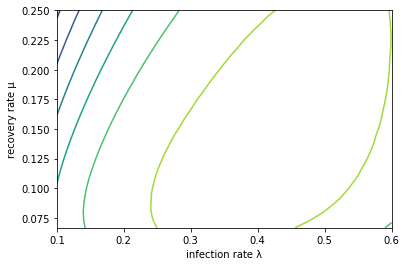

In [92]:
maxi = np.percentile(logp_mat, axis=(0,3,4), q=95)
print(maxi.shape)
plt.contour(np.exp(λ_r), np.exp(μ_r),maxi.T)
plt.xlabel('infection rate λ')
plt.ylabel('recovery rate μ')
np.max(np.sort)